# 네이버 영화리뷰 감정 분석: KoNLPy(Mecab) vs SentencePiece

## 목표
1. KoNLPy의 Mecab 형태소 분석기를 사용하여 네이버 영화 리뷰 데이터를 토큰화
2. SentencePiece 기반 모델과 동일한 전처리 및 모델 구조를 적용하여 감정 분석 모델을 학습
3. 학습된 모델의 성능을 SentencePiece 및 다른 KoNLPy 토크나이저를 사용한 모델과 비교 분석

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from soynlp.normalizer import emoticon_normalize
from konlpy.tag import Mecab
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

## 1. 데이터 로드 및 전처리

In [2]:
train_df = pd.read_table('ratings_train.txt')
test_df = pd.read_table('ratings_test.txt')

In [3]:
def preprocess_data(df, is_train=True):
    df_name = '훈련' if is_train else '테스트'
    print(f'--- {df_name} 데이터 전처리 ---')
    print(f'전처리 전 데이터 개수: {len(df)}')
    df.dropna(inplace=True)
    print(f'결측치 제거 후: {len(df)}개')
    if is_train:
        df.drop_duplicates(subset=['document'], inplace=True)
        print(f'중복 제거 후: {len(df)}개')
    df['document'] = df['document'].apply(lambda x: emoticon_normalize(x, num_repeats=2) if isinstance(x, str) else x)
    df.dropna(inplace=True)
    df = df[~df['document'].str.match('^[ㄱ-ㅎㅏ-ㅣ]+$', na=False)]
    min_char_len = 3
    max_char_len = 140
    df = df[df['document'].str.len() >= min_char_len]
    df['document'] = df['document'].str.slice(0, max_char_len)
    print(f'최종 데이터 개수: {len(df)}개')
    return df

train_df_clean = preprocess_data(train_df.copy(), is_train=True)
test_df_clean = preprocess_data(test_df.copy(), is_train=False)

--- 훈련 데이터 전처리 ---
전처리 전 데이터 개수: 150000
결측치 제거 후: 149995개
중복 제거 후: 146182개
최종 데이터 개수: 145594개
--- 테스트 데이터 전처리 ---
전처리 전 데이터 개수: 50000
결측치 제거 후: 49997개
최종 데이터 개수: 49369개


## 2. KoNLPy (Mecab) 토큰화

In [4]:
mecab = Mecab(dicpath='/opt/homebrew/lib/mecab/dic/mecab-ko-dic')

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def mecab_tokenize(corpus):
    tokenized_corpus = []
    for sentence in corpus:
        temp_X = mecab.morphs(sentence) # Mecab으로 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        tokenized_corpus.append(temp_X)
    return tokenized_corpus

X_train_tokenized = mecab_tokenize(train_df_clean['document'])
X_test_tokenized = mecab_tokenize(test_df_clean['document'])

### 단어장(Vocabulary) 생성

In [5]:
words = np.concatenate(X_train_tokenized).tolist()
counter = Counter(words)
vocab_size = 20000
vocab = counter.most_common(vocab_size - 2) # <pad>, <unk> 제외
word_to_index = {word[0]: index+2 for index, word in enumerate(vocab)}
word_to_index['<pad>'] = 0
word_to_index['<unk>'] = 1

def text_to_sequence(tokens, word_to_index):
    return [word_to_index.get(word, 1) for word in tokens] # 없으면 <unk>

X_train_seq = [text_to_sequence(tokens, word_to_index) for tokens in X_train_tokenized]
X_test_seq = [text_to_sequence(tokens, word_to_index) for tokens in X_test_tokenized]

def pad_sequences(sequences):
    sequences = [torch.tensor(seq, dtype=torch.long) for seq in sequences]
    return pad_sequence(sequences, batch_first=True, padding_value=word_to_index['<pad>'])

X_train_padded = pad_sequences(X_train_seq)
X_test_padded = pad_sequences(X_test_seq)

y_train = torch.tensor(train_df_clean['label'].values, dtype=torch.float32)
y_test = torch.tensor(test_df_clean['label'].values, dtype=torch.float32)

print('Mecab 토큰화 완료!')
print('Train data shape:', X_train_padded.shape)
print('Test data shape:', X_test_padded.shape)

Mecab 토큰화 완료!
Train data shape: torch.Size([145594, 116])
Test data shape: torch.Size([49369, 105])


## 3. 모델 학습 및 평가

In [6]:
# 훈련/검증 데이터 분리 및 DataLoader 생성
val_size = 40000
X_val, y_val = X_train_padded[:val_size], y_train[:val_size]
X_train_final, y_train_final = X_train_padded[val_size:], y_train[val_size:]

train_dataset = TensorDataset(X_train_final, y_train_final)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test_padded, y_test)

batch_size = 512
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

In [7]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, padding_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        out = self.fc(hidden)
        return self.sigmoid(out)

class CNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, out_channels=n_filters, kernel_size=fs)
            for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x).permute(0, 2, 1)
        conved = [torch.relu(conv(embedded)) for conv in self.convs]
        pooled = [torch.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim=1))
        out = self.fc(cat)
        return self.sigmoid(out)

In [8]:
def train_and_evaluate_with_plot(model, train_loader, val_loader, test_loader, num_epochs, device, lr=1e-3):
    model = model.to(device)
    criterion = nn.BCELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    print(f'--- {type(model).__name__} 모델 학습 시작 ---')
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss, epoch_train_correct, epoch_train_total = 0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            epoch_train_correct += (predicted == labels).sum().item()
            epoch_train_total += labels.size(0)
        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_train_acc = epoch_train_correct / epoch_train_total
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(avg_train_acc)
        model.eval()
        epoch_val_loss, epoch_val_correct, epoch_val_total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                epoch_val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                epoch_val_correct += (predicted == labels).sum().item()
                epoch_val_total += labels.size(0)
        avg_val_loss = epoch_val_loss / len(val_loader)
        avg_val_acc = epoch_val_correct / epoch_val_total
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(avg_val_acc)
        print(f'Epoch [{epoch+1}/{num_epochs}] -> Train Loss: {avg_train_loss:.4f}, Acc:{avg_train_acc:.4f} | Val Loss: {avg_val_loss:.4f}, Acc: {avg_val_acc:.4f}')
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            predicted = (outputs > 0.5).float()
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    test_accuracy = test_correct / test_total
    print(f'Final Test Accuracy: {test_accuracy:.4f}')
    return history, test_accuracy

def plot_history(history, model_name):
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy', color='darkblue', marker='o')
    plt.plot(history['val_acc'], label='Validation Accuracy', color='crimson', marker='o')
    plt.title(f'{model_name} - Accuracy', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss', color='darkblue', marker='o')
    plt.plot(history['val_loss'], label='Validation Loss', color='crimson', marker='o')
    plt.title(f'{model_name} - Loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [9]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

VOCAB_SIZE = len(word_to_index)
EMBEDDING_DIM = 128
HIDDEN_DIM = 128
OUTPUT_DIM = 1
NUM_EPOCHS = 7
LEARNING_RATE = 1e-3

bilstm_model_mecab = LSTMModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, padding_idx=word_to_index['<pad>'])
bilstm_history_mecab, bilstm_test_acc_mecab = train_and_evaluate_with_plot(bilstm_model_mecab, train_loader, val_loader, test_loader, NUM_EPOCHS, device, lr=LEARNING_RATE)

N_FILTERS = 100
FILTER_SIZES = [3,4,5]
DROPOUT = 0.5

cnn_model_mecab = CNNModel(VOCAB_SIZE, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)
cnn_history_mecab, cnn_test_acc_mecab = train_and_evaluate_with_plot(cnn_model_mecab, train_loader, val_loader, test_loader, NUM_EPOCHS, device, lr=LEARNING_RATE)

Using device: mps
--- LSTMModel 모델 학습 시작 ---
Epoch [1/7] -> Train Loss: 0.5180, Acc:0.7340 | Val Loss: 0.4074, Acc: 0.8145
Epoch [2/7] -> Train Loss: 0.3711, Acc:0.8360 | Val Loss: 0.3620, Acc: 0.8392
Epoch [3/7] -> Train Loss: 0.3191, Acc:0.8633 | Val Loss: 0.3397, Acc: 0.8503
Epoch [4/7] -> Train Loss: 0.2831, Acc:0.8807 | Val Loss: 0.3328, Acc: 0.8558
Epoch [5/7] -> Train Loss: 0.2504, Acc:0.8972 | Val Loss: 0.3430, Acc: 0.8584
Epoch [6/7] -> Train Loss: 0.2203, Acc:0.9111 | Val Loss: 0.3477, Acc: 0.8540
Epoch [7/7] -> Train Loss: 0.1914, Acc:0.9250 | Val Loss: 0.3609, Acc: 0.8604
Final Test Accuracy: 0.8551
--- CNNModel 모델 학습 시작 ---
Epoch [1/7] -> Train Loss: 0.5285, Acc:0.7265 | Val Loss: 0.4249, Acc: 0.8050
Epoch [2/7] -> Train Loss: 0.4141, Acc:0.8094 | Val Loss: 0.3787, Acc: 0.8316
Epoch [3/7] -> Train Loss: 0.3649, Acc:0.8383 | Val Loss: 0.3624, Acc: 0.8418
Epoch [4/7] -> Train Loss: 0.3289, Acc:0.8584 | Val Loss: 0.3513, Acc: 0.8481
Epoch [5/7] -> Train Loss: 0.3007, Acc:0.87

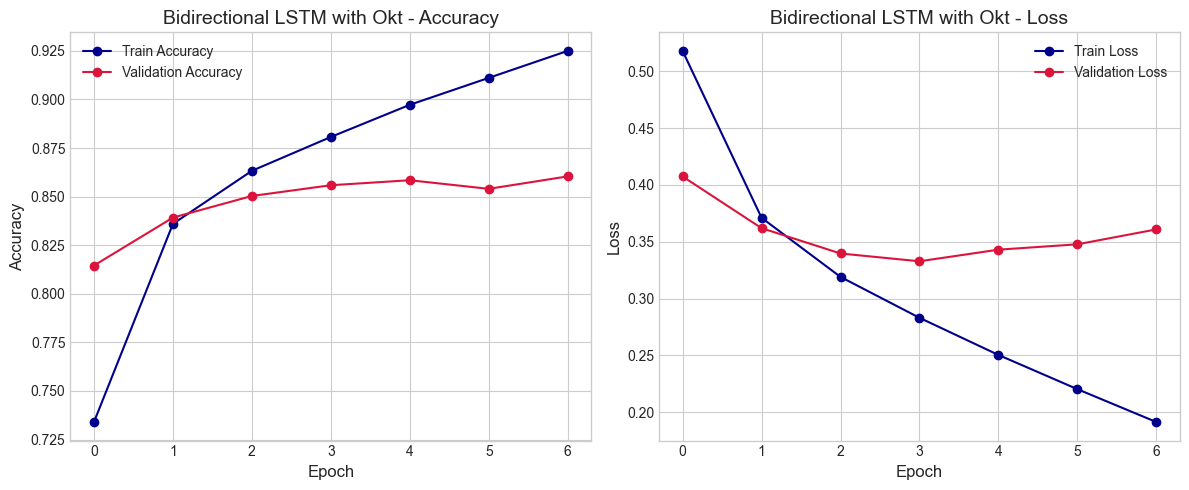

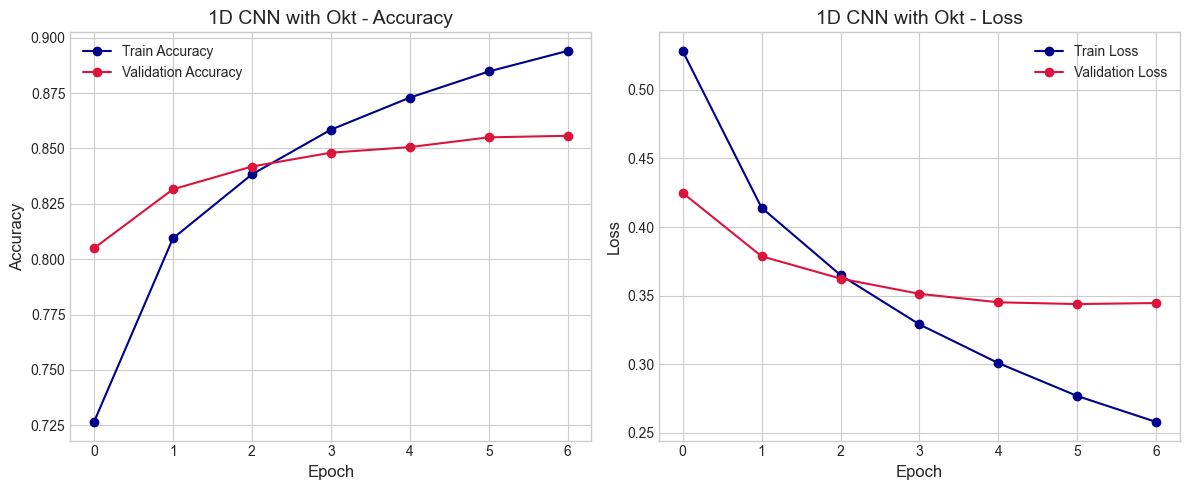

In [10]:
plot_history(bilstm_history_mecab, 'Bidirectional LSTM with Okt')
plot_history(cnn_history_mecab, '1D CNN with Okt')